<center>

---
---


<div style="display: flex; justify-content: space-between; align-items: center;">
    <img src="https://github.com/svenguenther/OLE/raw/main/docs/logos/OLE_trans.png" height="300" alt="OLÉ" />
    <img src="https://latex.codecogs.com/svg.latex?\times" height="50" alt="latex symbol" />
    <img src="https://raw.githubusercontent.com/Lbalkenhol/candl/main/docs/logos/candl_wordmark%26symbol_col_RGB.png" height="150" alt="candl" />
</div>

</center>

---
---

This notebook shows how to feed `candl` likelihoods into OLÉ and run the staged NUTS sampler. We use the SPT-3G 2018 TT/TE/EE lite likelihood to explore LCDM (https://arxiv.org/abs/2212.05642, https://arxiv.org/abs/2412.00826).

*Note*: the accuracy settings for CLASS are NOT sufficient for a real analysis. What we do here is hence just for demonstration purposes; the low accuracy settings chosen allow us to run the chains on a laptop in 10min.

*Requirements*: this tutorial uses:
* `candl` for the differentiable likelihood, install it via `pip install candl-like` [1]
* `getdist` for visualisation purposes, install it via `pip install getdist` [2]

[1] https://arxiv.org/abs/2401.13433, https://github.com/Lbalkenhol/candl

[2] https://arxiv.org/abs/1910.13970, https://github.com/cmbant/getdist


In [ ]:
# Necessary imports and setup
%matplotlib widget
import matplotlib.pyplot as plt
import os
import numpy as np

# OLE
from OLE.sampler import NUTSSampler
import OLE.plotting
from OLE.theories.CLASS import CLASS
from OLE.likelihoods.cosmo.candl import candl_likelihood
from OLE.sampler import NUTSSampler

# candl
import candl
import candl.data
import candl.plots

# Getdist
from getdist import MCSamples, plots

# Plot style
OLE.plotting.set_plot_style()

# Set up the Theory code and Emulator thereof, Likelihood, Sampler

In [ ]:
# Initialise the candl likelihood to be used.
# Here, we use the SPT-3G 2018 TT/TE/EE lite likelihood
candl_like = candl.Like(candl.data.SPT3G_2018_TTTEEE,
                        variant="lite")

Successfully initialised candl likelihood 'SPT-3G 2018 TT/TE/EE (lite)' (type: <class 'candl.likelihood.Like'>).
Data loaded from '/Users/lennart/Research/candl/candl/data/SPT3G_2018_TTTEEE_v0/'.
Functional likelihood form: gaussian
--------------------------------------------------------------------------------
It will analyse the following spectra:

TT lxl       (35 bins, bin centres spanning ell = 774.5 - 2946.8)
TE lxl       (44 bins, bin centres spanning ell = 325.2 - 2946.2)
EE lxl       (44 bins, bin centres spanning ell = 324.8 - 2945.9)
--------------------------------------------------------------------------------
A data model consisting of 2 transformations has been initialised.
The following transformations will be applied to the theory spectra in this order:

(1) Name: Aberration
    Type: <class 'candl.transformations.common.AberrationCorrection'>
(2) Name: Absolute Calibration
    Type: <class 'candl.transformations.common.CalibrationCross'>
----------------------------

In [65]:
# Create a temporary directory to store chains in
save_dir = "tmp_chains"
os.mkdir(save_dir)

In [ ]:
# Tweak the emulator settings
emulator_settings = {
    "working_directory": f"./{save_dir}/",
    "dimensionality": 6 + len(candl_like.required_nuisance_parameters),
    "N_sigma": 4.0,
}

# Pass likelihood information to OLE
likelihood_settings = {
    "candl_dataset": candl_like.data_set_file,
    "clear_priors": False,# the candl likelihood has its own priors (it really is a posterior) that we want to keep
}
my_likelihood_collection_settings = {"candl": likelihood_settings}

# Settings for the theory code
# Note that we *should* request higher accuracy settings here to get correct constraints, but for the sake of speed for this demonstration I'm using lower accuracy settings here
theory_settings = {
    "parameters": ["h", "n_s", "omega_b", "omega_cdm", "tau_reio", "logA"],
    "class_settings": {'output':'tCl,pCl,lCl'},
}

# Sampler settings
sampling_settings = {
    "output_directory": f"./{save_dir}",
    "minimize_nuisance_parameters": True,
    'M_adapt': 200,
}

In [ ]:
# Initialise the theory code, likelihood, and the sampler within OLE
my_theory = CLASS()
my_likelihood = candl_likelihood()
my_likelihood_collection = {"candl": my_likelihood}
my_sampler = NUTSSampler()

In [ ]:
# Define the parameters to be sampled
my_parameters = {
    "h": {
        "prior": {"min": 0.60, "max": 0.80},
        "ref": {"mean": 0.68, "std": 0.014997123265365231},
        "proposal": 0.014997123265365231,
    },
    "n_s": {
        "prior": {"min": 0.9, "max": 1.1},
        "ref": {"mean": 0.96, "std": 0.016369727493579424},
        "proposal": 0.016369727493579424,
    },
    "omega_b": {
        "prior": {"min": 0.02, "max": 0.024},
        "ref": {"mean": 0.0223, "std": 0.0003139414805568362},
        "proposal": 0.0003139414805568362,
    },
    "omega_cdm": {
        "prior": {"min": 0.10, "max": 0.14},
        "ref": {"mean": 0.120, "std": 0.0037665050030121585},
        "proposal": 0.0037665050030121585,
    },
    "tau_reio": {
        "prior": {"min": 0.01, "max": 0.1},
        "ref": {"mean": 0.055, "std": 0.007333674923082461},
        "proposal": 0.007333674923082461,
    },
    "logA": {
        "prior": {"min": 2.8, "max": 3.3},
        "ref": {"mean": 3.1, "std": 0.02046167052074405},
        "proposal": 0.02046167052074405,
    },
    "Tcal": {
        "latex": "T_\\mathrm{cal}",
        "prior": {"min": 0.9, "max": 1.1},
        "ref": {"mean": 1.0, "std": 0.004196517474014392},
        "proposal": 0.004196517474014392,
    },
    "Ecal": {
        "latex": "E_\\mathrm{cal}",
        "prior": {"min": 0.9, "max": 1.1},
        "ref": {"mean": 1.0, "std": 0.00512604718246002},
        "proposal": 0.00512604718246002,
    },
}

# Run the Chains

In [ ]:
# Run the sampler! The different phases should take about:
# MH sampling with CLASS:           2 minutes
# Emulator training & minisation :  2 minutes
# NUTS sampling:                    4 minutes

my_sampler.initialize(
    theory=my_theory,
    likelihood_collection=my_likelihood_collection,
    parameters=my_parameters,
    emulator_settings=emulator_settings,
    likelihood_collection_settings=my_likelihood_collection_settings,
    theory_settings=theory_settings,
    sampling_settings=sampling_settings,
    debug=False,
)

n_steps = 1e3
my_sampler.run_mcmc(int(n_steps))

2025-02-20 15:30:02,055 - Emulator - INFO - Emulator initialized


2025-02-20 15:30:02,439 - Emulator - WARNING - Data covmat not found for quantity tt. Not using it for normalization.
2025-02-20 15:30:02,439 - Emulator - WARNING - Data covmat not found for quantity ee. Not using it for normalization.
2025-02-20 15:30:02,439 - Emulator - WARNING - Data covmat not found for quantity te. Not using it for normalization.
2025-02-20 15:30:02,440 - Emulator - INFO - Create emulator for tt
2025-02-20 15:30:02,440 - Emulator - INFO - Create emulator for ee
2025-02-20 15:30:02,440 - Emulator - INFO - Create emulator for te
2025-02-20 15:30:02,443 - NUTSSampler - INFO - Starting NUTS
2025-02-20 15:30:05,037 - DataCache - INFO - Cache size: 1/500
2025-02-20 15:30:05,048 - DataCache - INFO - Cache size: 1/500
2025-02-20 15:30:05,055 - DataCache - INFO - Cache size: 1/500
2025-02-20 15:30:05,061 - DataCache - INFO - Cache size: 2/500
2025-02-20 15:30:07,414 - DataCache - INFO - Cache size: 2/500
2025-02-20 15:30:07,422 - DataCache - INFO - Cache size: 3/500
2025-0

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

2025-02-20 15:33:50,096 - DataCache - INFO - Cache size: 81/500
2025-02-20 15:33:58,486 - NUTSSampler - INFO - Starting minimization after first emulator training to find bestfit and covmat.
2025-02-20 15:34:08,739 - MinimizeSampler - INFO - Minimization results of 1 restarts
2025-02-20 15:34:08,740 - MinimizeSampler - INFO - Mean loglike: 50.99646166465642 +- 0.0
2025-02-20 15:34:10,247 - MinimizeSampler - INFO - Quality criterium not fulfilled for best fit! Adding new state to emulator
2025-02-20 15:34:10,757 - DataCache - INFO - Cache size: 64/500
2025-02-20 15:34:31,340 - MinimizeSampler - INFO - Minimization results of 1 restarts
2025-02-20 15:34:31,341 - MinimizeSampler - INFO - Mean loglike: 50.86725980875578 +- 0.12920185590063937
2025-02-20 15:34:32,934 - MinimizeSampler - WARNING - Quality criterium not fulfilled for best fit after adding a new state to the emulator.
2025-02-20 15:35:04,310 - NUTSSampler - INFO - Minimization after first emulator training finds:
2025-02-20 15

# Analyse the Chains

In [ ]:
# Cast samples into a getdist object
sample_pars = list(my_sampler.parameter_dict.keys())
chain = my_sampler.chain

gd_samples_NUTS = MCSamples(samples = chain,
                            names = sample_pars,
                            labels = [candl.plots.PAR_LABEL_DICT[p] if p in candl.plots.PAR_LABEL_DICT else p for p in sample_pars],
                            label='OLE NUTS')
gd_samples_NUTS.loglikes = np.zeros(len(chain))

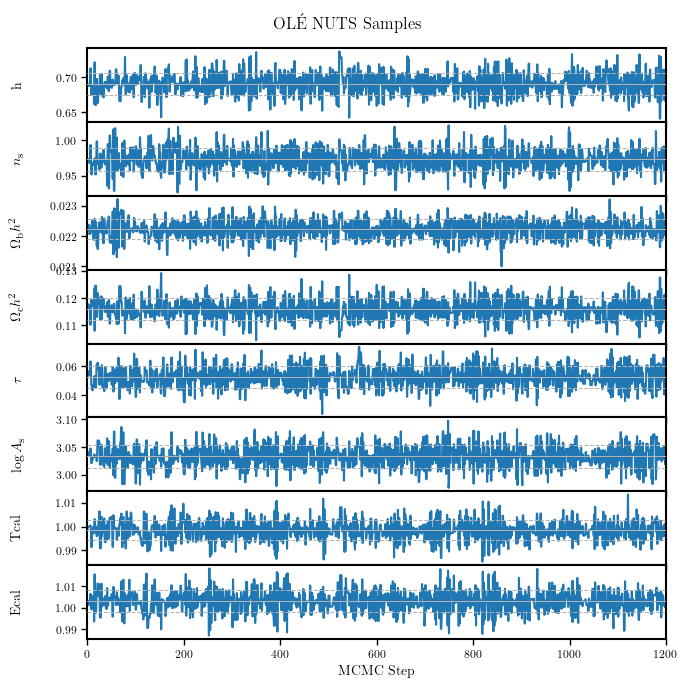

In [ ]:
# Plot the samples
plt.close()

fig, ax = candl.plots.plot_mcmc_chain_steps(gd_samples_NUTS,# samples to plot
                                            sample_pars,# parameters to plot
                                            {p: np.mean(chain[:,i]) for i,p in enumerate(sample_pars)},# Posterior mean
                                            np.cov(chain.T),# Covariance matrix from the chain
                                            sample_pars,# Order of parameters in covariance matrix
                                            show_logl=False)

plt.suptitle("OLÉ NUTS Samples")
plt.tight_layout()

plt.show()

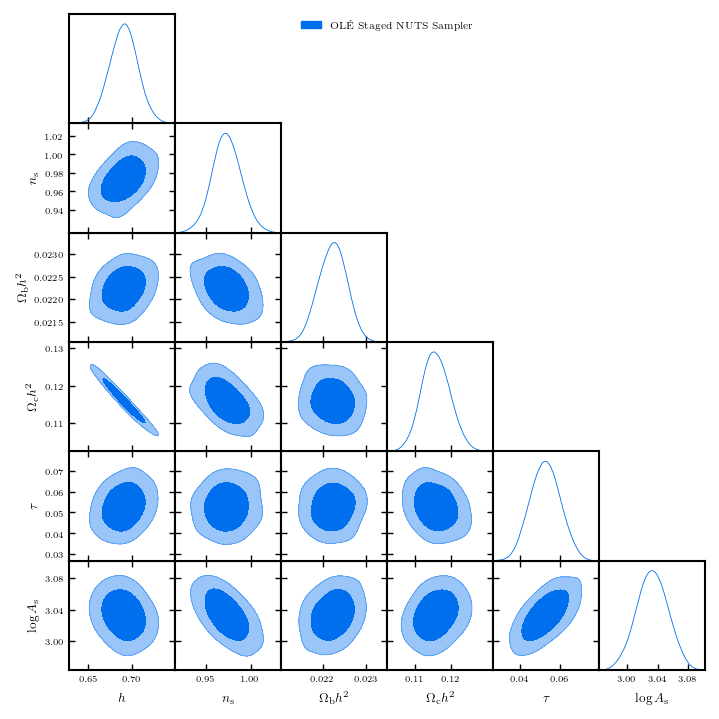

In [ ]:
# Make a triangle plot
# Note, these chains are clearly not converged, but this is just a demonstration
plt.close()

g = plots.get_subplot_plotter(subplot_size=1.2)
g.triangle_plot(gd_samples_NUTS,
                sample_pars[:-2],
                filled=True,
                legend_labels=["OLÉ Staged NUTS Sampler"])

plt.show()

In [ ]:
# Cleanup!
# Delete the chain files
for file in os.listdir(f"./{save_dir}"):
    os.remove(f"./{save_dir}/{file}")
os.rmdir(f"./{save_dir}")